In [43]:
# Helpers
import pickle
import numpy as np
import time

# DB 
import psycopg2
from django.conf import settings

# Learning
from fdtf import feedback_driven_tensor_factorization
from sklearn.cluster import AgglomerativeClustering

# Evaluation
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from skbio.stats.distance import anosim
from skbio import DistanceMatrix

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                                  password = settings.DATABASES["default"]["PASSWORD"],
                                  host = settings.DATABASES["default"]["HOST"],
                                  port = settings.DATABASES["default"]["PORT"],
                                  database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

In [26]:
%%time
query_test = """select experiment_id, sp, x, sp_hat from edm2020_2020_02_19 
where method='fdtf' order by train_rmse limit 10"""

cursor.execute(query_test)
rows = cursor.fetchall()

CPU times: user 9.95 s, sys: 775 ms, total: 10.7 s
Wall time: 8min 43s


In [73]:
%%time
query_test = """select experiment_id, sp, x, sp_hat from edm2020_2020_02_19 
where method='fdtf' order by test_rmse limit 10"""

cursor.execute(query_test)
rows_test = cursor.fetchall()

CPU times: user 885 ms, sys: 48.1 ms, total: 933 ms
Wall time: 36.3 s


Proportional: 0.13
Acc: 0.67
F-Score: 0.20
Train 1: 672
Train 1 Pred: 669
LL: -0.71
[[2067  538]
 [ 541  131]]


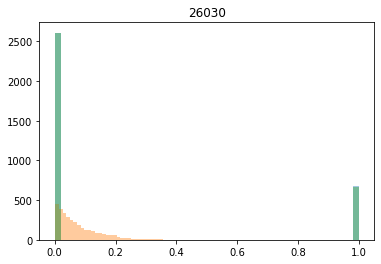

Proportional: 0.14
Acc: 0.66
F-Score: 0.18
Train 1: 649
Train 1 Pred: 648
LL: -0.70
[[1982  534]
 [ 535  114]]


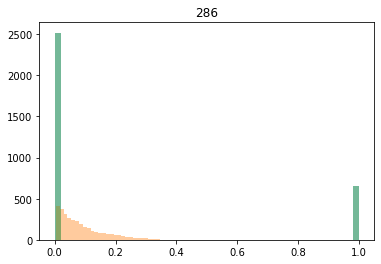

Proportional: 0.16
Acc: 0.67
F-Score: 0.19
Train 1: 672
Train 1 Pred: 671
LL: -0.70
[[2062  543]
 [ 544  128]]


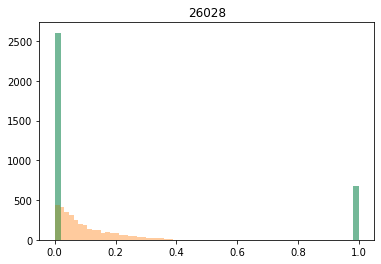

Proportional: 0.16
Acc: 0.67
F-Score: 0.19
Train 1: 672
Train 1 Pred: 671
LL: -0.69
[[2060  545]
 [ 546  126]]


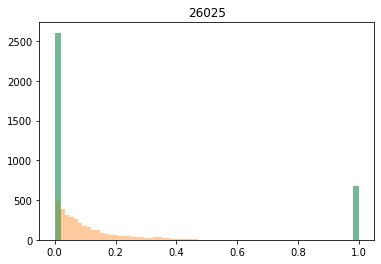

Proportional: 0.18
Acc: 0.66
F-Score: 0.18
Train 1: 594
Train 1 Pred: 593
LL: -0.67
[[1763  485]
 [ 486  108]]


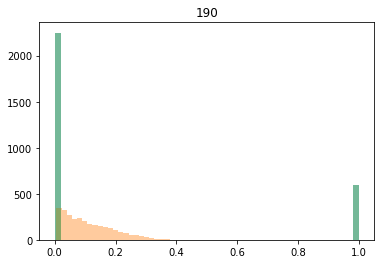

Proportional: 0.20
Acc: 0.67
F-Score: 0.19
Train 1: 649
Train 1 Pred: 648
LL: -0.66
[[1993  523]
 [ 524  125]]


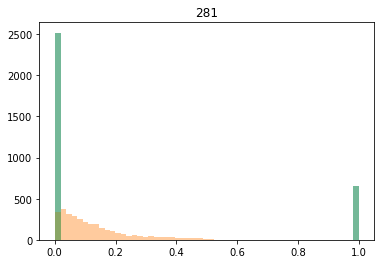

Proportional: 0.15
Acc: 0.67
F-Score: 0.19
Train 1: 672
Train 1 Pred: 671
LL: -0.70
[[2060  545]
 [ 546  126]]


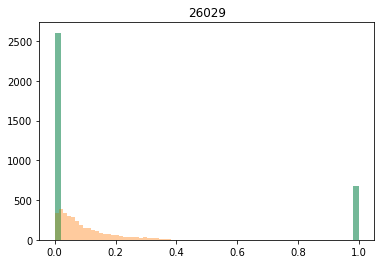

Proportional: 0.16
Acc: 0.67
F-Score: 0.19
Train 1: 672
Train 1 Pred: 671
LL: -0.69
[[2060  545]
 [ 546  126]]


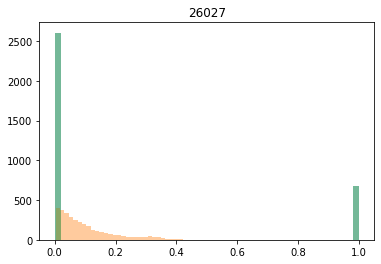

Proportional: 0.15
Acc: 0.67
F-Score: 0.20
Train 1: 672
Train 1 Pred: 671
LL: -0.70
[[2067  538]
 [ 539  133]]


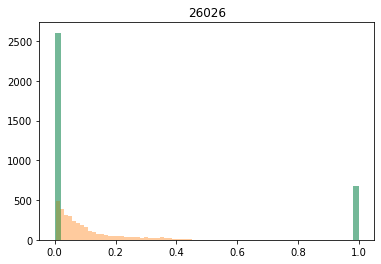

Proportional: 0.18
Acc: 0.67
F-Score: 0.18
Train 1: 672
Train 1 Pred: 671
LL: -0.69
[[2057  548]
 [ 549  123]]


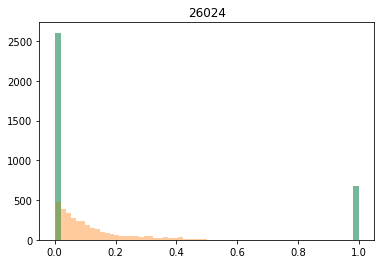

In [96]:
experiments_train = []
for row in rows:
    exp_id, sp, X, sp_hat = row
    X = np.asarray(X)
    sp = np.asarray(sp)
    sp_hat = np.asarray(sp_hat)
    
    attempts_per_question = X.sum(axis=0).sum(axis=1)
    del_questions = [idx for idx,value in enumerate(attempts_per_question) if value < 3]
    X = np.delete(X, del_questions, axis=1)
    
    # Get train predicted values
    plt.figure()
    y = sp[np.where(X == 1)]
    y_pred = sp_hat[np.where(X == 1)]
    
    y_pred_sorted =y_pred.copy()
    y_pred_sorted.sort()
    train_1 = np.where(y == 1)[0].shape[0]
    y_pred_binary = np.where(np.asarray(y_pred) > y_pred_sorted[-train_1], 1, 0)
    acc = np.logical_not(np.logical_xor(y, y_pred_binary)).sum()/len(y)
    f1 = f1_score(y, y_pred_binary)
    train_pred_1 = np.where(y_pred_binary == 1)[0].shape[0]
    y_pred_all = np.zeros((y.shape[0], 2))
    y_pred_all[:,0] = 1-y_pred
    y_pred_all[:,1] = y_pred
    ll = -np.mean(np.log(y_pred_all[range(y.shape[0]), y.astype(int)]))
    
    print("Proportional: %.2f" % y_pred_sorted[-train_1])
    print("Acc: %.2f" % acc)
    print("F-Score: %.2f" % f1)
    print("Train 1: %d" % train_1)
    print("Train 1 Pred: %d" % train_pred_1)
    print("LL: %.2f" % ll)
    print(confusion_matrix(y,y_pred_binary))
        
    sns.distplot(y, kde=False)
    sns.distplot(y_pred, kde=False)
    sns.distplot(y_pred_binary, kde=False)
    plt.title("%d" % exp_id)
    plt.show()
    
     # Calculate AUC and threshold to binarize prediction
#     fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
#     auc_score = auc(fpr, tpr)
#     plt.figure()
#     lw = 2
#     plt.plot(fpr, tpr, color='darkorange',
#              lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()
    
    experiments_train.append(exp_id)

In [152]:
from scipy import special

In [261]:
%%time
query = """select experiment_id, sp_test, sp_hat, x, x_test, sk_hat, q_matrix_hat, mu, auc_threshold
from EDM2020_2020_02_19 where method='fdtf' and experiment_id=41"""
cursor.execute(query)

CPU times: user 10.6 ms, sys: 12 ms, total: 22.7 ms
Wall time: 9.96 s


In [262]:
row = cursor.fetchone()

In [267]:
%%time
update_queries = []
total = 0
error_count = 0

exp_id, sp_test, sp_hat, X, X_test, sk_hat, q_matrix_hat, mu, auc_threshold = row
sp_test = np.asarray(sp_test)
sp_hat = np.asarray(sp_hat)
sk_hat = np.asarray(sk_hat)
X_test = np.asarray(X_test)
sp_hat_test = np.zeros((sp_hat.shape[0], sp_hat.shape[1], sp_test.shape[2]))
attempts = min(sp_test.shape[2], sp_hat.shape[2])
sp_hat_test[:, :, :attempts] = sp_hat[:, :, :attempts]
sk_hat_test = np.zeros((sk_hat.shape[0], sk_hat.shape[1], sp_test.shape[2]))
sk_hat_test[:, :, :attempts] = sk_hat[:, :, :attempts]
q_matrix_hat = np.asarray(q_matrix_hat)

# Calculate SK and SP for the next test attempts
for attempt in range(1, attempts):
    students = np.where(X_test[:,:, attempt] == 1)
    for student in students:
        sk_hat_test[student, :, attempt] = (2*sk_hat_test[student, :, attempt-1]) + \
                                        2*(1-sk_hat_test[student, :, attempt-1])/(1+np.exp(
                                            -mu*np.dot(X_test[student, :, attempt], q_matrix_hat.T))) - 1
        sp_hat_test[student, :, attempt] = np.dot(sk_hat_test[student, :, attempt], q_matrix_hat)

# Get test predicted values
y = sp_test[np.where(X_test == 1)]
y_pred = sp_hat_test[np.where(X_test == 1)]

# Binarize prediction
y_pred_binary = np.where(np.asarray(y_pred) > auc_threshold, 1, 0)

# Calculate accuracy, RMSE, F1, NLL
acc = np.logical_not(np.logical_xor(y, y_pred_binary)).sum()/len(y)
rmse = np.sqrt(np.power((y-y_pred), 2)).mean()
f1 = f1_score(y, y_pred_binary)
nll = -special.xlogy(y, y_pred) - special.xlogy(1-y, 1-y_pred)

y_pred_all = np.zeros((y.shape[0], 2))
y_pred_all[:,0] = 1-y_pred
y_pred_all[:,1] = y_pred
nll_special = (-np.ma.log(y_pred_all[range(y.shape[0]),y.astype(int)])).mean()

# Substitute inf by max NLL
idx = np.where(np.isinf(nll))
nll[idx] = 0
max_nll = np.max(nll)
nll[idx] = max_nll
nll = np.mean(nll)

update = {
    "test_acc": acc,
    "test_rmse": rmse,
    "test_1":  np.where(y == 1)[0].shape[0],
    "test_0":  np.where(y == 0)[0].shape[0],
    "test_pred_1": np.where(y_pred_binary == 1)[0].shape[0],
    "test_pred_0": np.where(y_pred_binary == 0)[0].shape[0],
    "test_f1": f1,
    "test_nll": nll,
    "test_nll_special": nll_special,
    "test_nll_masked": idx[0].shape[0]
}
    

CPU times: user 97.6 ms, sys: 0 ns, total: 97.6 ms
Wall time: 101 ms


In [268]:
update

{'test_acc': 0.5752688172043011,
 'test_rmse': 0.42105771368309025,
 'test_1': 59,
 'test_0': 127,
 'test_pred_1': 50,
 'test_pred_0': 136,
 'test_f1': 0.2752293577981651,
 'test_nll': 1.8684467736343737,
 'test_nll_special': 0.7894348233309708,
 'test_nll_masked': 44}

In [72]:
experiments_test = []
for row in rows_test:
    exp_id, sp_test, sp_hat, X, X_test, sk_hat, q_matrix_hat, mu, auc_threshold = row
    sp_test = np.asarray(sp_test)
    sp_hat = np.asarray(sp_hat)
    sk_hat = np.asarray(sk_hat)
    X = np.asarray(X)
    X_test = np.asarray(X_test)
    sp_hat_test = np.zeros((sp_hat.shape[0], sp_hat.shape[1], sp_test.shape[2]))
    attempts = min(sp_test.shape[2], sp_hat.shape[2])
    sp_hat_test[:, :, :attempts] = sp_hat[:, :, :attempts]
    sk_hat_test = np.zeros((sk_hat.shape[0], sk_hat.shape[1], sp_test.shape[2]))
    sk_hat_test[:, :, :attempts] = sk_hat[:, :, :attempts]
    q_matrix_hat = np.asarray(q_matrix_hat)
    
    # Update X_test shape
    attempts_per_question = X.sum(axis=0).sum(axis=1)
    del_questions = [idx for idx,value in enumerate(attempts_per_question) if value < 3]
    X_test = np.delete(X_test, del_questions, axis=1)
    sp_test = np.delete(sp_test, del_questions, axis=1)
    
    # Calculate SK and SP for the next test attempts
    for attempt in range(1, attempts):
        students = np.where(X_test[:,:, attempt] == 1)
        for student in students:
            sk_hat_test[student, :, attempt] = (2*sk_hat_test[student, :, attempt-1]) + \
                                            2*(1-sk_hat_test[student, :, attempt-1])/(1+np.exp(
                                                -mu*np.dot(X_test[student, :, attempt], q_matrix_hat.T))) - 1
            sp_hat_test[student, :, attempt] = np.dot(sk_hat_test[student, :, attempt], q_matrix_hat)
    
    # Get train predicted values
    y = sp_test[np.where(X_test == 1)]
    y_pred = sp_hat_test[np.where(X_test == 1)]
    
    y_pred_sorted =y_pred.copy()
    y_pred_sorted.sort()
    test_1 = np.where(y == 1)[0].shape[0]
    y_pred_binary = np.where(np.asarray(y_pred) > y_pred_sorted[-test_1], 1, 0)
    acc = np.logical_not(np.logical_xor(y, y_pred_binary)).sum()/len(y)
    f1 = f1_score(y, y_pred_binary)
    test_pred_1 = np.where(y_pred_binary == 1)[0].shape[0]
    
    print("Proportional: %.2f" % y_pred_sorted[-test_1])
    print("Acc: %.2f" % acc)
    print("F-Score: %.2f" % f1)
    print("Train 1: %d" % test_1)
    print("Train 1 Pred: %d" % test_pred_1)
    print(confusion_matrix(y,y_pred_binary))
        
    sns.distplot(y, kde=False)
    sns.distplot(y_pred, kde=False)
    sns.distplot(y_pred_binary, kde=False)
    plt.title("%d" % exp_id)
    plt.show()
    
    experiments_test.append(exp_id)

NameError: name 'rows_test' is not defined

In [ ]:
row[0]

In [64]:
tuple(experiments_train)

(26030, 286, 26028, 26025, 190, 281, 26029, 26027, 26026, 26024)

In [49]:
experiments_train = (
    # Best FDTF train_rmse 
    26030, 
#     277, 
    # Best NMF train_rmse with 1 attempt (so we can calculate accuracy) and overall
#     52473,
#     52126
)
experiments_q_matrix = (
    # Best FDTF Q-Matrix rmse
#     274,
#     17805,
    # Best NMF Q-Matrix rmse,
#     56936,
#     56954
)

experiments_test = (
    # Best FDTF test rmse
#     17,
    #16
    # Best NMF test rmse,

    )

In [65]:
query = """select q_matrix, q_matrix_hat, concepts, method, experiment_id 
from EDM2020_2020_02_19 where experiment_id in %s """
# or experiment_id in %s or experiment_id in %s"""
# query = """select q_matrix, q_matrix_hat, q_matrix_rmse from edm2020_2020_02_19 
# where method='fdtf' order by q_matrix_rmse"""

query = cursor.mogrify(query, (tuple(experiments_train),))# experiments_q_matrix, experiments_test))
cursor.execute(query)
response = cursor.fetchall()

In [66]:
data = {}
for idx, row in enumerate(response):
    data[idx] = {}
    data[idx]['exp_id'] = row[-1]
    data[idx]['method'] = row[-2]
    if data[idx]['exp_id'] in experiments_train:
        data[idx]['type'] = 'train_rmse'
    elif data[idx]['exp_id'] in experiments_test:
        data[idx]['type'] = 'test_rmse'
    else:
        data[idx]['type'] = 'q_matrix_rmse'
    data[idx]['concepts'] = row[2]
    print("%d - %s - %s" % (data[idx]['exp_id'], data[idx]['method'], data[idx]['type']))
    data[idx]['q_matrix'] = np.asarray(row[0])
    q_matrix = data[idx]['q_matrix']
#     row_sums = data[idx]['q_matrix'].sum(axis=0)
#     data[idx]['q_matrix_norm'] = data[idx]['q_matrix'] / row_sums
    data[idx]['q_matrix_hat'] = np.asarray(row[1])
    q_matrix_hat = data[idx]['q_matrix_hat']
#     row_sums = data[idx]['q_matrix_hat'].sum(axis=0)
#     data[idx]['q_matrix_norm_hat'] = data[idx]['q_matrix_hat'] / row_sums
    data[idx]['question_similarity'] = cosine_similarity(q_matrix.T)
    data[idx]['question_distance'] = cosine_distances(q_matrix.T)
    data[idx]['question_hat_similarity'] = cosine_similarity(q_matrix_hat.T)
    data[idx]['question_hat_distance'] = cosine_distances(q_matrix_hat.T)
    error = data[idx]['question_similarity'] - data[idx]['question_hat_similarity']
    data[idx]['error'] = np.sqrt(np.sum(np.power(error,2)))
    data[idx]['rmse'] = np.sqrt(np.mean(np.power(error,2)))
    qs = data[idx]['question_similarity']
    qs_hat = data[idx]['question_hat_similarity']
    data[idx]['cmd'] = 1-np.trace(np.dot(qs,
                                         qs_hat))/(np.linalg.norm(qs)*np.linalg.norm(qs_hat))
    print(data[idx]['cmd'])

190 - fdtf - train_rmse
0.2934930471537247
281 - fdtf - train_rmse
0.2570014146625078
286 - fdtf - train_rmse
0.2774950123569253
26024 - fdtf - train_rmse
0.24705709700824485
26025 - fdtf - train_rmse
0.2398644276567038
26026 - fdtf - train_rmse
0.24464726296677142
26027 - fdtf - train_rmse
0.2779089027455871
26028 - fdtf - train_rmse
0.27048581702371877
26029 - fdtf - train_rmse
0.2595720626575647
26030 - fdtf - train_rmse
0.3009935870922348


In [67]:
import pandas as pd

In [68]:
df = pd.DataFrame.from_dict(data, orient='index').set_index('exp_id')
df = df[['method', 'concepts', 'type', 'error', 'rmse', 'cmd']]

In [69]:
df

,method,concepts,type,error,rmse,cmd
exp_id,,,,,,
190,fdtf,7,train_rmse,18.157182,0.378275,0.293493
281,fdtf,8,train_rmse,17.983306,0.374652,0.257001
286,fdtf,13,train_rmse,16.607123,0.345982,0.277495
26024,fdtf,10,train_rmse,17.697634,0.368701,0.247057
26025,fdtf,11,train_rmse,16.794523,0.349886,0.239864
26026,fdtf,12,train_rmse,16.718649,0.348305,0.244647
26027,fdtf,13,train_rmse,16.980592,0.353762,0.277909
26028,fdtf,14,train_rmse,16.101093,0.335439,0.270486
26029,fdtf,15,train_rmse,15.990968,0.333145,0.259572


In [70]:
from sklearn.cluster import AgglomerativeClustering

In [71]:
for idx in range(len(data)):
    print("%d - %d - %s - %s - %d" % (idx, data[idx]['exp_id'], data[idx]['method'], 
                                      data[idx]['type'], data[idx]['concepts']))
    print(data[idx]['cmd'])
    models = []
    dm = DistanceMatrix(data[idx]['question_distance'])
    stats_list = []
    p_values = []
    for i in range(2, 20):
        model = AgglomerativeClustering(n_clusters=i, 
                                        affinity='cosine',
                                        linkage='single').fit(data[idx]['q_matrix_hat'].T)
    #     model = SpectralClustering(n_clusters=i, n_init=100, affinity='precomputed').fit(
    #         data[idx]['question_hat_similarity'].T)
    #     model = SpectralClustering(n_clusters=i, n_init=100, affinity='rbf').fit(
    #         data[idx]['q_matrix_hat'].T)
    #     model = KMeans(n_clusters=i, n_init=100).fit(data[idx]['q_matrix_hat'].T)
        models.append(model)
        stats = anosim(dm, model.labels_, permutations=9999)
        stats_list.append(stats['test statistic'])
        p_values.append(stats['p-value'])
    print(np.where(np.asarray(p_values) < 0.1)[0]+1)
    print(np.asarray(stats_list)[np.where(np.asarray(p_values) < 0.1)])
    print()

0 - 190 - fdtf - train_rmse - 7
0.2934930471537247
[]
[]

1 - 281 - fdtf - train_rmse - 8
0.2570014146625078
[]
[]

2 - 286 - fdtf - train_rmse - 13
0.2774950123569253
[]
[]

3 - 26024 - fdtf - train_rmse - 10
0.24705709700824485
[]
[]

4 - 26025 - fdtf - train_rmse - 11
0.2398644276567038
[4 5 6 7 8]
[0.13054899 0.12946265 0.13256709 0.12857463 0.13129902]

5 - 26026 - fdtf - train_rmse - 12
0.24464726296677142
[5]
[0.12265781]

6 - 26027 - fdtf - train_rmse - 13
0.2779089027455871
[4 5]
[0.14712613 0.16371109]

7 - 26028 - fdtf - train_rmse - 14
0.27048581702371877
[3 4 5 6 8]
[0.19310763 0.12685892 0.14810839 0.11076904 0.09679846]

8 - 26029 - fdtf - train_rmse - 15
0.2595720626575647
[]
[]

9 - 26030 - fdtf - train_rmse - 16
0.3009935870922348
[]
[]



In [378]:
stats_list

[0.031143933460146832,
 -0.07877606756022211,
 -0.04087854087854093,
 -0.03789377766206707,
 -0.04706930746140639,
 0.039631190169772366,
 0.04229587095851908,
 0.0758107956458309,
 0.07643988701952605,
 0.04786588582884877,
 0.038074348649297304,
 0.05036541643684499,
 0.05218367418528789,
 0.019998600097993036,
 0.038588804980688216,
 0.035056068484912876,
 0.026571418228330694,
 0.005022954361328564]

In [351]:
p_values

[0.12,
 0.42,
 0.28,
 0.56,
 0.73,
 0.42,
 0.63,
 0.59,
 0.42,
 0.72,
 0.74,
 0.86,
 0.59,
 0.6,
 0.67,
 0.68,
 0.52,
 0.51]

### Organizing data

In [3]:
def add_to_tensor(data, tensor, X, filter_attempt=False):
    for item in data:
        s_idx, q_idx, a_idx, outcome = item

        # If attempt is over max value, ignore it
        if filter_attempt and a_idx >= filter_attempt:
            continue

        tensor[s_idx, q_idx, a_idx] = outcome
        X[s_idx, q_idx, a_idx] = 1
        
    tensor[np.where(X[:,:] == 0)] = None
    return tensor, X
    
def transform_data(data, n_attempts):
    N_STUDENTS = len(data['users_idx'])
    N_QUESTIONS = len(data['questions_idx'])
    
    student_performance = np.zeros((N_STUDENTS, N_QUESTIONS, n_attempts))
    X = np.zeros(student_performance.shape)

    student_performance, X = add_to_tensor(data['train_set'], 
                                           student_performance, 
                                           X, filter_attempt=n_attempts)
    
    
    max_attempt = np.max(data['test_set'][:,2])+1
    student_performance_test = np.zeros((N_STUDENTS, N_QUESTIONS, max_attempt))
    X_test = np.zeros(student_performance_test.shape)
    student_performance_test, X_test = add_to_tensor(data['test_set'], 
                                                     student_performance_test, 
                                                     X_test)
    return student_performance, X, student_performance_test, X_test

Do grid search to explore parameters

In [5]:
# %%time
# mu = [0.1, 0.5, 1, 3, 10]
mu = [3]
# n_concepts = range(2, 20)
n_concepts = [14]
# attempts = [10, 20, 50, 100, 150, 200]
attempts = [10]

In [24]:
search = 1 * N_RUNS * len(attempts) * len(mu) * len(n_concepts)
search

2700

In [18]:
def run(*args):
    dataset, data, att, student_performance, X, student_performance_test, X_test, del_questions, m, concept = args
    
    # Run FDTF
    start = time.time()
    (best_student_performance_pred, best_student_knowledge, 
     best_q_matrix, best_error) = feedback_driven_tensor_factorization(
        student_performance, n_concepts=concept, init=10, max_iter=1000, mu=m)
#                     student_performance, n_concepts=concept, init=1, max_iter=3, mu=m)
    end = time.time()

    if concept == 14:
        q_matrix = np.delete(data['q_matrix'], del_questions, axis=1)
        q_matrix_error = np.sqrt(np.sum(np.power(q_matrix-best_q_matrix, 2)))
    else:
        q_matrix = data['q_matrix']
        q_matrix_error = -1

    row = {
        "dataset": "run_%d" % dataset,
        "q_matrix": q_matrix,
        "X": X,
        "sp": student_performance,
        "X_test": X_test,
        "sp_test": student_performance_test,
        "sp_hat": best_student_performance_pred,
        "sk_hat": best_student_knowledge,
        "q_matrix_hat": best_q_matrix,
        "mu": m,
        "concepts": concept,
        "attempts_train": att,
        "method": "fdtf",
        "q_matrix_error": q_matrix_error,
        "reconstruction_error": best_error,
        "train_error": 0,
        "test_error": 0,
        "seconds": end-start
    }
    
    return row

In [19]:
args = []
for restart in range(1):
    for dataset in range(N_RUNS):
        with open("%s/run_%d.pkl" % (folder, dataset), "rb") as pklfile:
            data = pickle.load(pklfile)
        for att in attempts:
            # Get train and test data in FDTF format
            student_performance, X, student_performance_test, X_test = transform_data(data, att)
            # Check if questions have minimum number of attempts
            attempts_per_question = X.sum(axis=0).sum(axis=1)
            del_questions = [idx for idx,value in enumerate(attempts_per_question) if value < 3]
            student_performance = np.delete(student_performance, del_questions, axis=1)
            
            for m in mu:
                for concept in n_concepts:                
                    args.append([dataset, 
                                data, 
                                att, 
                                student_performance, 
                                X, 
                                student_performance_test, 
                                X_test, 
                                del_questions,
                                m,
                                concept])

In [20]:
len(args)

5

In [21]:
%%time
row = run(*args[0])

CPU times: user 2min 9s, sys: 3.93 s, total: 2min 13s
Wall time: 1min 7s


In [25]:
rmse = np.sqrt(np.mean(np.power(row['q_matrix']-row['q_matrix_hat'], 2)))
rmse

0.4616764283646856